<a href="https://colab.research.google.com/github/dsadasafd/CNN/blob/main/CNN__humanface_celeba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
from google.colab import drive
drive.mount('./mount')

Drive already mounted at ./mount; to attempt to forcibly remount, call drive.mount("./mount", force_remount=True).


In [11]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import h5py
import numpy, pandas, random
import matplotlib.pyplot as plt


In [12]:
# check NVIDIA CUDA

if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda", torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cpu


In [13]:
x = torch.tensor([1.0])
print(x.device)

cpu


In [14]:
def crop_centre(img, new_width, new_height):
  height, weight, _ = img.shape
  startx = weight//2 - new_width//2
  starty = height//2 -new_height//2
  return img[starty:starty+new_height, startx:startx+new_width]


class View(nn.Module):

  def __init__(self, shape):
    super().__init__()
    self.shape = shape,

  def forward(self, x):
    return x.view(*self.shape)

# 随机函数生成
def generate_random_image(size):
  random_data = torch.rand(size)
  return random_data

def generate_random_seed(size):
  random_data = torch.randn(size)
  return random_data

In [15]:
class CelebADataset(Dataset):

  def __init__(self, file):

    super().__init__()
    self.file_object = h5py.File(file, 'r')
    self.dataset = self.file_object['img_align_celeba']
    pass


  def __len__(self):

    return len(self.dataset)


  def __getitem__(self, index):

    if (index >= len(self.dataset)):
      raise IndexError()
    img = numpy.array(self.dataset[str(index)+'.jpg'])
    # 裁剪正方形图片
    new_img = crop_centre(img, 128, 128)

    return torch.cuda.FloatTensor(new_img).view(1,3,128,128) / 255.0


  def plot_image(self, index):
    img = numpy.array(self.dataset[str(index)+'.jpg'])
    new_img = crop_centre(img, 128, 128)
    plt.imshow(new_img, interpolation='nearest')
    pass

pass



<HDF5 dataset "25.jpg": shape (218, 178, 3), type "|u1">


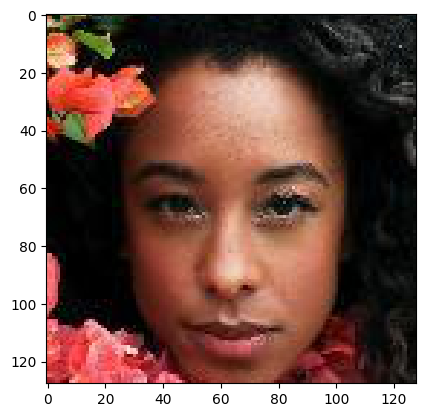

In [20]:
celeba_dataset = CelebADataset('./mount/My Drive/Colab Notebooks/celeba_data/celeba_aligned_small.h5py')

print(celeba_dataset.dataset['25.jpg'])

celeba_dataset.plot_image(43)

In [21]:
# create discriminator class

class Discriminator(nn.Module):

  def __init__(self):

    # 继承父类
    super().__init__()

    # 神经网络架构
    self.model = nn.Sequential(

        # 输入图像形状（1，3，128，128）
        nn.Conv2d(3, 256, kernel_size=8, stride=2), # 3通道，256个卷积核，8*8卷积矩阵深度为3，步长2，得到低级特征图大小为61*61
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2),

        nn.Conv2d(256, 256, kernel_size=8, stride=2), # 中级特征图大小为27*27
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2),

        nn.Conv2d(256, 3, kernel_size=8, stride=2),  # 高级特征图大小10*10
        # nn.BatchNorm2d(3),
        nn.LeakyReLU(0.2),

        View(3*10*10),
        nn.Linear(3*10*10, 1),
        nn.Sigmoid()

    )

    # 损失函数
    self.loss_function = nn.BCELoss()

    # 优化器
    self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

    # 计数器和误差记录
    self.counter = 0
    self.loss_progress = []

    pass



  def forward(self, inputs):
    return self.model(inputs)


  def train(self, inputs, targets):

    outputs = self.model(inputs)
    loss = self.loss_function(outputs, targets)

    self.counter += 1

    if self.counter % 10 == 0:
      self.loss_progress.append(loss.item())

    if self.counter % 1000 == 0:
      print('counter = ', self.counter)

    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()

    pass



  def plot_progress(self):

    df = pandas.DataFrame(self.loss_progress, columns=['loss'])
    df.plot(ylim=(0), figsize=(16, 8), alpha=0.1, marker='.', grid=True, yticks=(0.0, 0.25, 0.5, 1.0, 5.0))
    pass

pass







In [23]:
%%time

# 测试鉴别器

D = Discriminator()
D.to(device)

for image_data_tensor in celeba_dataset:

  # 真实数据训练
  D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))

  # 随机数据训练
  D.train(generate_random_image((1,3,128,128)), torch.cuda.FloatTensor([0.0]))

  pass

RuntimeError: ignored

In [19]:
D.plot_progress()

TypeError: ignored

In [ ]:
# 测试鉴别器性能

for i in range(4):
  image_data_tensor = celeba_dataset[random.randint(0,20000)]
  print(D.forward(image_data_tensor).item())

for i in range(4):
  print(D.forward(generate_random_image((1,3,128,128))).item())

In [ ]:
# 创建生成器

class Generator(nn.Module):

  def __init__(self):
    super().__init__()

    self.model = nn.Sequential(
        # 输入为一维数组，用随机种子生成器
        nn.Linear(100, 3*11*11),
        nn.LeakyReLU(0.2),

        # 转换成带深度的通道图
        View((1,3,11,11)),

        # 输入卷积层, 得到一个28*28的输出特征图
        nn.ConvTranspose2d(3, 256, kernel_size=8, stride=2),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2),

        # 第二个卷积层，62*62
        nn.ConvTranspose2d(256, 256, kernel_size=8, stride=2),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2),

        # 第三个卷积层，有补全，说明中间网格外围减少一周0值，的带128*128
        nn.ConvTranspose2d(256, 3, kernel_size=8, stride=2, padding=1),
        nn.BatchNorm2d(3),

        nn.Sigmoid()
    )

    self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

    self.counter = 0
    self.loss_progress = []
    pass

  def forward(self, inputs):

    return self.model(inputs)



  def train(self, D, inputs, targets):

    g_outputs = self.forward(inputs)
    d_outputs = D.forward(g_outputs)

    loss = D.loss_function(d_outputs, targets)

    self.counter += 1
    if self.counter % 10 == 0:
      self.loss_progress.append(loss.item())
      pass



    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()

    pass


  def plot_progress(self):

    df = pandas.DataFrame(self.loss_progress, columns=['loss'])
    df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
    pass



In [ ]:
G = Generator()
G.to(device)

output = G.forward(generate_random_seed(100))
img = output.detach().permute(0,2,3,1).view(128,128,3).cpu().numpy()
plt.imshow(img, interpolation='none', cmap='Blues')

In [ ]:
# 训练整个GAN

%%time

D = Discriminator()
G = Generator()
D.to(device)
G.to(device)

epochs = 1

for epoch in range(epochs):
  print("epoch = ", epoch+1)

  for image_data_tensor in celeba_dataset:
    # 真实数据集
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))

    # 随机数据集
    D.train(G.forward(generate_random_seed(100)).detach(), torch.cuda.FloatTensor([0.0]))

    # 训练生成器
    G.train(D, generate_random_seed(100), torch.cuda.FloatTensor([1.0]))

    pass

  pass




In [ ]:
D.plot_progress()

In [ ]:
G.plot_progress()

In [ ]:
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
  for j in range(3):
    output = G.forward(generate_random_seed(100))
    img = output.detach().permute(0,2,3,1).view(128,128,3).cpu().numpy()
    axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
    pass

  pass



In [ ]:
torch.cuda.memory_allocated(device) / (1024^3)

In [ ]:
torch.cuda.max_memory_allocated(device) / (1024^3)

In [ ]:
print(torch.cuda.memory_summary(device, abbreviated=True))